#RSF

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import pandas as pd
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored
from sklearn.metrics import mean_squared_error



In [10]:
## Uncomment to install `sklearn-pandas`
# ! pip install sklearn-pandas

## Feature transforms
We have 9 covariates, in addition to the durations and event indicators.

We will standardize the 5 numerical covariates, and leave the binary variables as is. As variables needs to be of type `'float32'`, as this is required by pytorch.

In [11]:
# Load dataset
np.random.seed(1234)
data = pd.read_csv("data/Recurrence free survival in breast cancer patients.csv")

# Define column types
CONTINUOUS_VARIABLES = ["age", "size", "nodes", "prog", "oest"]
CATEGORICAL_VARIABLES = ["treat", "men", "grade"]

# Scale continuous variables
# scaler = MinMaxScaler()
# data[CONTINUOUS_VARIABLES] = scaler.fit_transform(data[CONTINUOUS_VARIABLES])

# One-hot encode categorical variables
data = pd.get_dummies(data, columns=CATEGORICAL_VARIABLES, drop_first=True)

# Sort by status to isolate uncensored samples
data = data.sort_values("status").reset_index(drop=True)

# Select last 100 uncensored rows for test set
uncensored = data[data["status"] == 1]
df_test = uncensored.iloc[-75:]
df_trainval = data.drop(df_test.index)

# Sample 20% of training set for validation
df_val = df_trainval.sample(frac=0.2, random_state=42)
df_train = df_trainval.drop(df_val.index)

# Define predictors after one-hot encoding
PREDS = [
    "age", "size", "nodes", "prog", "oest",
    "treat_1", "men_2", "grade_2", "grade_3"
]

# Features
x_train = df_train[PREDS].astype("float32").values
x_val = df_val[PREDS].astype("float32").values
x_test = df_test[PREDS].astype("float32").values

# Targets
get_target = lambda df: (df["time"].astype(float).values, df["status"].astype(bool).values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

# Convert to structured array format for scikit-survival
y_train_structured = Surv.from_arrays(event=y_train[1], time=y_train[0])
y_val_structured = Surv.from_arrays(event=y_val[1], time=y_val[0])
y_test_structured = Surv.from_arrays(event=events_test, time=durations_test)


In [12]:
df_test[PREDS]

,age,size,nodes,prog,oest,treat_1,men_2,grade_2,grade_3
611,48,22,4,14,0,False,True,True,False
612,52,35,1,8,5,False,True,False,True
613,60,21,1,58,701,False,True,True,False
614,48,35,10,2,222,False,False,False,True
615,59,27,20,9,2,False,True,False,True
...,...,...,...,...,...,...,...,...,...
681,68,14,6,40,68,True,True,True,False
682,64,24,2,41,80,False,True,True,False
683,58,56,11,51,50,True,True,False,False
684,51,34,3,13,12,True,False,True,False


We need no label transforms

## Parameters

In [13]:
# Train Random Survival Forest model
rsf = RandomSurvivalForest(n_estimators=100,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=42)

rsf.fit(x_train, y_train_structured)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10, n_jobs=-1,
                     random_state=42)

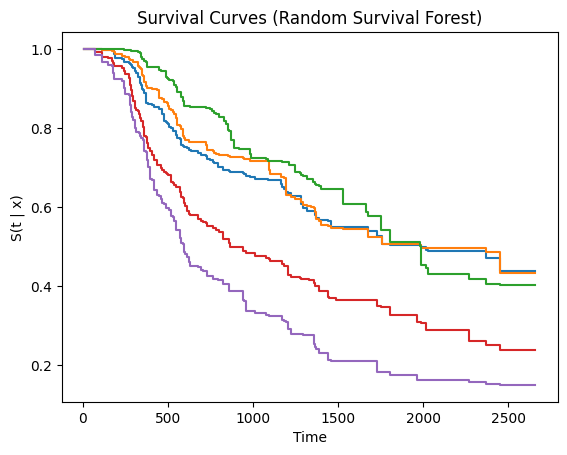

In [14]:
# Predict survival functions
surv_funcs = rsf.predict_survival_function(x_test, return_array=False)

# Plot first 5 survival curves
for fn in surv_funcs[:5]:
    plt.step(fn.x, fn.y)
plt.ylabel("S(t | x)")
plt.xlabel("Time")
plt.title("Survival Curves (Random Survival Forest)")
plt.show()

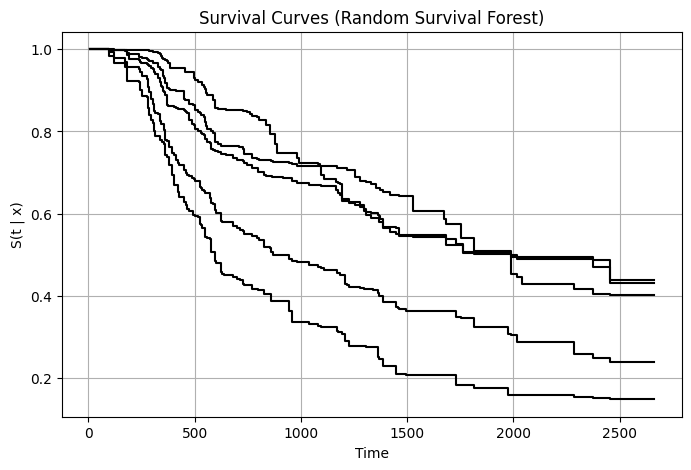

In [18]:
# Plot first 5 survival curves (Black lines, no legend)
plt.figure(figsize=(8, 5))
for fn in surv_funcs[:5]:
    plt.step(fn.x, fn.y, where="post", color="black")

plt.title("Survival Curves (Random Survival Forest)")
plt.xlabel("Time")
plt.ylabel("S(t | x)")
plt.grid(True)
plt.show()


In [15]:
# Evaluate
c_index = concordance_index_censored(events_test, durations_test, rsf.predict(x_test))[0]
print(f"Concordance Index: {c_index:.3f}")

#C-index for training data 
c_index_train = concordance_index_censored(y_train[1], y_train[0], rsf.predict(x_train))[0]
print(f"Training Concordance Index: {c_index_train:.3f}")


Concordance Index: 0.623
Training Concordance Index: 0.782


In [16]:
# Predict survival functions
surv_funcs = rsf.predict_survival_function(x_test, return_array=False)

# Get common time grid
time_grid = surv_funcs[0].x
expected_survival_times = []

for fn in surv_funcs:
    # Estimate expected survival time by numerical integration
    est_time = np.trapz(fn.y, fn.x)
    expected_survival_times.append(est_time)

expected_survival_times = np.array(expected_survival_times)

# Calculate RMSE against true durations
rmse = np.sqrt(mean_squared_error(durations_test, expected_survival_times))
print(f"RMSE of expected survival time: {rmse:.2f}")

#RMSE for training data (only on uncensored records)
# Get uncensored training rows
uncensored_train_mask = y_train[1] == True
x_train_uncensored = x_train[uncensored_train_mask]
durations_train_uncensored = y_train[0][uncensored_train_mask]

# Predict survival functions for uncensored training data
surv_funcs_train = rsf.predict_survival_function(x_train_uncensored, return_array=False)

# Estimate expected survival times using integration
expected_train_times = []
for fn in surv_funcs_train:
    est_time = np.trapz(fn.y, fn.x)
    expected_train_times.append(est_time)

# Compute RMSE on uncensored training set
rmse_train = np.sqrt(mean_squared_error(durations_train_uncensored, expected_train_times))
print(f"Training RMSE (uncensored only): {rmse_train:.2f}")


RMSE of expected survival time: 917.93
Training RMSE (uncensored only): 911.24
